# <center> Задача восстановления регрессии</center>
## <center>Lasso- и Ridge-регрессия</center>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from cycler import cycler
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold, cross_val_score

**Будем работать с набором данных по ценам на дома в Бостоне (репозиторий UCI).**
**Загружаем данные.**

In [ ]:
boston = load_boston()
X, y = boston["data"], boston["target"]

**Почитаем описание набора данных:**

In [ ]:
print(boston.DESCR)

**Признаки:**
- CRIM - количество преступлений на душу населения
- ZN - процент жилых участков площадью больше 25 тыс. кв. футов (~ 23 сотки)
- INDUS - процент площадей под оптовую торговлю 
- CHAS - протекает ли река
- NOX - концентрация оксидов азота
- RM - среднее число комнат в здании
- AGE - доля зданий, построенных до 1940 года 
- DIS - взвешенное расстояние до 5 деловых центров Бостона
- RAD - индекс доступности скоростных магистралей
- TAX - уровень налогов
- PTRATIO - среднее число учащихся на одного преподавателя 
- B - процент афроамериканцев
- LSTAT - процент граждан с низким уровнем жизни
- MEDV (целевой) - медианная стоимости домов в районе

In [ ]:
boston.feature_names

**Посмотрим на первые 2 записи.**

In [ ]:
X[:2]

## Lasso-регрессия

Lasso-регрессия решает задачу минимизации среднеквардатичной ошибки с L1-регуляризацией:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d |w_i|$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

**Обучим Lasso-регрессию с небольшим коэффициентом $\alpha$ (слабая регуляризация). Обнуляется только коэффициент при признаке NOX (концентрация оксидов азота). Значит, он наименее важен для предсказания целевого признака – медианной стоимости домов в районе.**

In [ ]:
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
lasso.coef_

**Обучим Lasso-регрессию с коэффициентом $\alpha=10$. Теперь ненулевые коэффициенты остались только при признаках ZN (процент жилых участков площадью больше 25 тыс. кв. футов), TAX (уровень налогов), B (процент афроамериканцев) и LSTAT (процент граждан с низким уровнем жизни).**

In [ ]:
lasso = Lasso(alpha=10)
lasso.fit(X, y)
lasso.coef_

**Таким образом, Lasso-регрессия служит методом отбора признаков.**

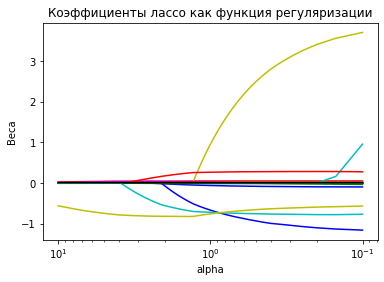

In [12]:
n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)
model = Lasso()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)

ax = plt.gca()
ax.set_prop_cycle(cycler("color", ["b", "r", "g", "c", "k", "y", "m"]))

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("Веса")
plt.title("Коэффициенты лассо как функция регуляризации")
plt.axis("tight")
plt.show();

**Теперь определим лучшее значение $\alpha$ в процессе кросс-валидации.**

In [ ]:
lasso_cv = LassoCV(alphas=alphas, cv=3, random_state=17)
lasso_cv.fit(X, y)

In [14]:
lasso_cv.coef_ж

array([-0.09739888,  0.04946381, -0.02749478,  0.16060406, -0.        ,
        3.55971374, -0.00726968, -1.13393157,  0.28096773, -0.01503453,
       -0.77985441,  0.01025033, -0.58259584])

In [15]:
lasso_cv.alpha_

0.14974874371859298

**Метод `cross_val_score` максимизирует метрику, так что вместо 
минимизации MSE сделаем максимизацию отрицательного MSE – `neg_mean_squared_error`.**

In [16]:
cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=3, scoring="neg_mean_squared_error")

array([-16.89312641, -37.56646167, -72.42092752])

**Чтобы все-таки трактовать результат в терминах MSE, выведем модуль среднего значения метрики `neg_mean_squared_error` на кросс-валидации.**

In [17]:
abs(
    np.mean(
        cross_val_score(
            Lasso(lasso_cv.alpha_), X, y, cv=3, scoring="neg_mean_squared_error"
        )
    )
)

42.293505199150765

In [18]:
abs(np.mean(cross_val_score(Lasso(9.95), X, y, cv=3, scoring="neg_mean_squared_error")))

53.72266087715847

**Еще один неоднозначный момент: LassoCV сортирует значения параметров по убыванию – так проще оптимизировать. Из-за этого может показаться, что оптимизация параметра $\alpha$ работает неправильно**

In [ ]:
lasso_cv.alphas[:10]  # значения параметров на входе

In [ ]:
lasso_cv.alphas_[:10]  # преобразованные значения параметров

In [ ]:
plt.plot(lasso_cv.alphas, lasso_cv.mse_path_.mean(1))  # неверно
plt.axvline(lasso_cv.alpha_, c="g");

In [ ]:
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(1))  # верно
plt.axvline(lasso_cv.alpha_, c="g");

## Ridge-регрессия

Ridge-регрессия (или гребневая регрессия) решает задачу минимизации среднеквардатичной ошибки с L2-регуляризацией:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d w_i^2$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

В sklearn реализован специальный класс [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) для кросс-валидации с Ridge-регрессией.

In [ ]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

In [ ]:
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring="neg_mean_squared_error", cv=3)
ridge_cv.fit(X, y)

In [ ]:
ridge_cv.alpha_

**В случае Ridge-регрессии никакие праметры не зануляются – они могут быть очень малыми, но не нулевыми.**

In [ ]:
ridge_cv.coef_

In [ ]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)
model = Ridge()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)

ax = plt.gca()
ax.set_prop_cycle(cycler("color", ["b", "r", "g", "c", "k", "y", "m"]))

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()